# Временные ряды. Лабораторная работа №2. Кочетков Максим, ШАД-312

## Libraries in use

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

## Reading dataset

In [61]:
passenger_etalon = pd.read_csv("passengers.csv")
passengers2 = pd.read_csv("passengers2.csv")

In [62]:
passenger_etalon.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [63]:
passengers2.head()

,Month,reference,target,missing
0,1949-01-01,112,112.0,NaN
1,1949-02-01,118,118.0,NaN
2,1949-03-01,132,132.0,NaN
3,1949-04-01,129,NaN,129.0
4,1949-05-01,121,121.0,NaN


In [64]:
passengers2.shape

(144, 4)

In [65]:
passengers2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   reference  144 non-null    int64  
 2   target     116 non-null    float64
 3   missing    28 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.6+ KB


## Task 1

1). Восполнение предыдущими значениями. Также как вариант можно применить восполнение последующими значениями, но это может привести к утечке данных/упреждению, если данные будут использовать для для построения прогнозной модели. Нужно сделать восполнение предыдущими значениями с помощью метода shift в pandas.

In [66]:
def refill_by_previous_values(dataframe, column='target'):
    dataframe[column] = dataframe[column].fillna(dataframe[column].shift(1))
    return dataframe

In [67]:
new_dataframe1 = refill_by_previous_values(passengers2.copy())

In [68]:
new_dataframe1.head()

,Month,reference,target,missing
0,1949-01-01,112,112.0,NaN
1,1949-02-01,118,118.0,NaN
2,1949-03-01,132,132.0,NaN
3,1949-04-01,129,132.0,129.0
4,1949-05-01,121,121.0,NaN


In [69]:
new_dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   reference  144 non-null    int64  
 2   target     141 non-null    float64
 3   missing    28 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.6+ KB


## Task 2

2). Восполнение данных с помощью скользящего среднего. Нужно выполнить двумя способами: с помощью формулы как среднее предыдущих значений (при значении window = 3), с помощью метода rolling в pandas в сочетании с методом mean.  

In [70]:
def refill_by_rolling_mean_1(dataframe, column='target', window=3):
    for string_index, string in enumerate(dataframe[column]):
        if pd.isna(string):
            if string_index >= window:
                dataframe.loc[string_index, column] = dataframe.loc[string_index-window:string_index, column].mean()
            else:
                dataframe.loc[string_index, column] = dataframe.loc[:string_index, column].mean()
    return dataframe

In [71]:
new_dataframe2_1 = refill_by_rolling_mean_1(passengers2.copy())

In [72]:
new_dataframe2_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   reference  144 non-null    int64  
 2   target     144 non-null    float64
 3   missing    28 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.6+ KB


In [73]:
def refill_by_rolling_mean_2(dataframe, column='target', window=3):
    dataframe[column] = dataframe[column].fillna(dataframe[column].rolling(window=window, min_periods=1).mean())
    return dataframe

In [74]:
new_dataframe2_2 = refill_by_rolling_mean_2(passengers2.copy())

In [75]:
new_dataframe2_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   reference  144 non-null    int64  
 2   target     144 non-null    float64
 3   missing    28 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.6+ KB


## Task 3

Интерполяция (линейная). Пропущенное значение вычисляется с помощь соседних по правилу пропорции (см. формулу для y).(x0, y0) - координаты точки слева, (x1, y1) - координаты точки справа, (x, y) - точка между ними, где x - временная метка, y - значение признака в ней.

Если точка с пропущенным значением находится посередине, то можно посчитать значение в ней как среднее арифметическое.Нужно посчитать, используя формулу, а затем построить интерполяцию с использованием метода interpolate в pandas .

In [92]:
def refill_by_interpolation_1(dataframe, column='target'):
    dataframe['date'] = pd.to_datetime(dataframe['Month'])
    dataframe['year'] = dataframe['date'].dt.year
    dataframe['month_number'] = dataframe['date'].dt.month

    dataframe['date'] = dataframe['year'] * 12 + dataframe['month_number']
    min_value = dataframe['date'].min()
    dataframe['date'] = dataframe['date'] - min_value

    for string_index, string in enumerate(dataframe[column]):
        if pd.isna(string):
            x0, y0 = dataframe.loc[string_index-1, 'date'], dataframe.loc[string_index-1, column]
            x1, y1 = dataframe.loc[string_index+1, 'date'], dataframe.loc[string_index+1, column]

            x = dataframe.loc[string_index, 'date']
            y = (y0 * (x1 - x) + y1 * (x - x0)) / (x1 - x0)

            dataframe.loc[string_index, column] = y
            
    return dataframe[['Month', 'reference', 'target', 'missing']]

In [93]:
new_dataframe3_1 = refill_by_interpolation_1(passengers2.copy())

In [94]:
new_dataframe3_1.head()

,Month,reference,target,missing
0,1949-01-01,112,112.0,NaN
1,1949-02-01,118,118.0,NaN
2,1949-03-01,132,132.0,NaN
3,1949-04-01,129,126.5,129.0
4,1949-05-01,121,121.0,NaN


In [ ]:
new_dataframe3_1.info()

In [83]:
def refill_by_interpolation_2(dataframe, column='target'):
    dataframe[column] = dataframe[column].interpolate(method='linear')
    return dataframe

In [84]:
new_dataframe3_2 = refill_by_interpolation_2(passengers2.copy())

In [85]:
new_dataframe3_2.head()

,Month,reference,target,missing
0,1949-01-01,112,112.0,NaN
1,1949-02-01,118,118.0,NaN
2,1949-03-01,132,132.0,NaN
3,1949-04-01,129,126.5,129.0
4,1949-05-01,121,121.0,NaN


In [86]:
new_dataframe3_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   reference  144 non-null    int64  
 2   target     144 non-null    float64
 3   missing    28 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.6+ KB


## Task 4

4). Для всех трёх способов, применённых по отдельности, построить графики, на которых должны быть данные по полю target (с заполненными пропущенными значениями) и данные из поля reference.

In [135]:
final_datasets = [new_dataframe1, new_dataframe2_1, new_dataframe2_2, new_dataframe3_1, new_dataframe3_2]
dataset_titles = [
    'Refilled by previos value',
    'Refilled by rolling mean',
    'Refilled by rolling mean pandas',
    'Refilled by interpolation',
    'Refilled by interpolation pandas'
]

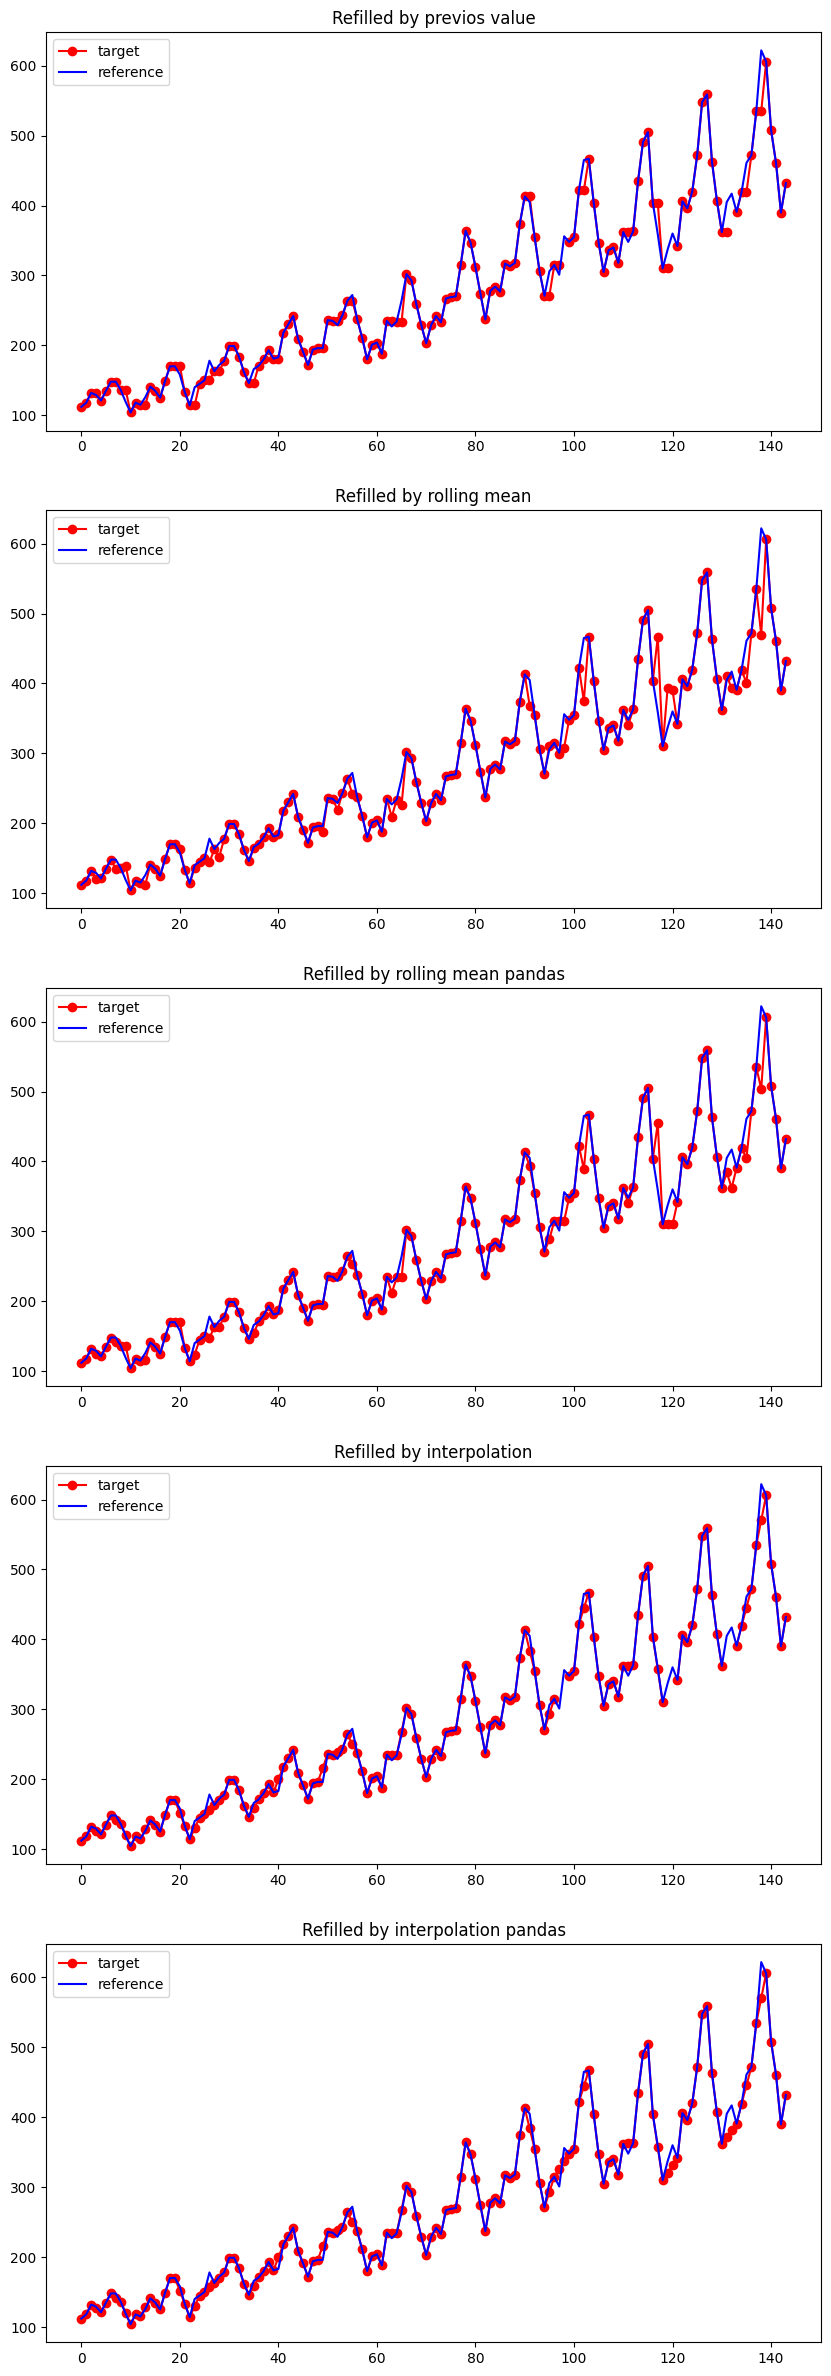

In [136]:
fig, axes = plt.subplots(nrows=len(final_datasets), ncols=1, figsize=(10, 30))

for dataset_index, dataset in enumerate(final_datasets):
    axes[dataset_index].plot(dataset['target'], color='red', label='target', marker='o')
    axes[dataset_index].plot(dataset['reference'], color='blue', label='reference')
    axes[dataset_index].set_title(dataset_titles[dataset_index])
    axes[dataset_index].legend()
plt.show()

## Task 5

In [116]:
def exponential_refill(dataframe, d: float):
    dataframe_length = dataframe.shape[0]
    for string_index in range(dataframe_length):
        if string_index == 0:
            previos_s = dataframe.loc[string_index, 'reference']
            dataframe['smoothed_reference'] = previos_s
        else:
            previos_s = dataframe.loc[string_index - 1, 'smoothed_reference']
            s = d * previos_s + (1 - d) * dataframe.loc[string_index, 'reference']
            dataframe.loc[string_index, 'smoothed_reference'] = s
    return dataframe

In [117]:
exponential_refill_dataframe = exponential_refill(passengers2.copy(), d=0.2)

In [118]:
exponential_refill_dataframe.head()

,Month,reference,target,missing,smoothed_reference
0,1949-01-01,112,112.0,NaN,112.0000
1,1949-02-01,118,118.0,NaN,116.8000
2,1949-03-01,132,132.0,NaN,128.9600
3,1949-04-01,129,NaN,129.0,128.9920
4,1949-05-01,121,121.0,NaN,122.5984


In [123]:
def exponential_refill_pandas(dataframe, d: float):
    dataframe['smoothed_reference'] = dataframe['reference'].ewm(alpha=d).mean()
    return dataframe

In [129]:
exponential_refill_dataframe_pandas = exponential_refill_pandas(passengers2.copy(), d=0.7)

In [130]:
exponential_refill_dataframe_pandas.head()

,Month,reference,target,missing,smoothed_reference
0,1949-01-01,112,112.0,NaN,112.000000
1,1949-02-01,118,118.0,NaN,116.615385
2,1949-03-01,132,132.0,NaN,127.683453
3,1949-04-01,129,NaN,129.0,128.612562
4,1949-05-01,121,121.0,NaN,123.270788


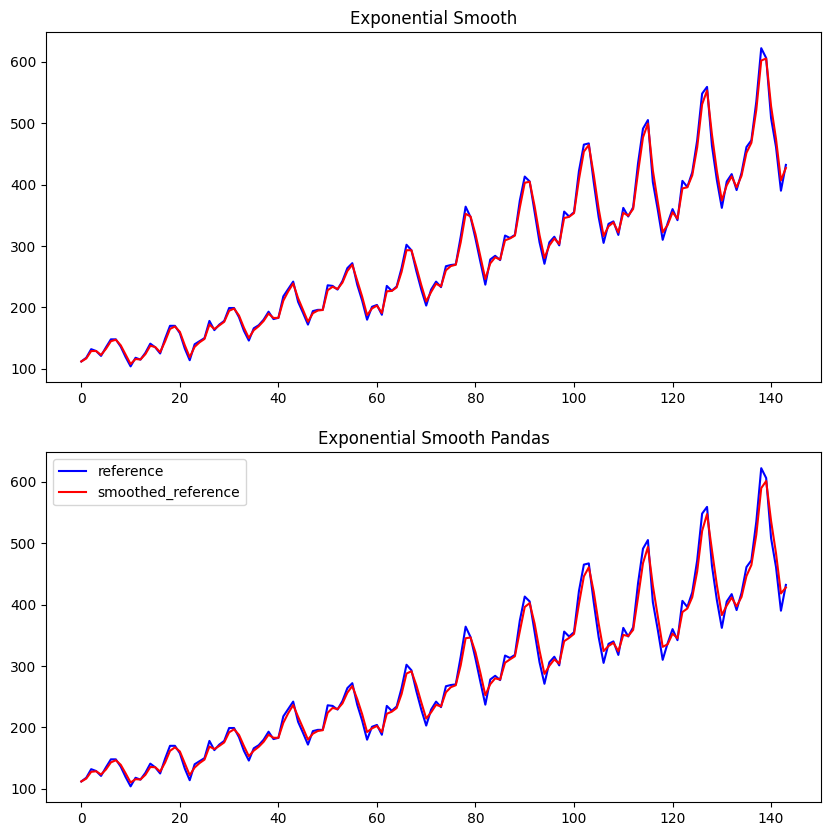

In [132]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes[0].plot(exponential_refill_dataframe['reference'], color='blue', label='reference')
axes[0].plot(exponential_refill_dataframe['smoothed_reference'], color='red', label='smoothed_reference')
axes[0].set_title('Exponential Smooth')
axes[1].plot(exponential_refill_dataframe_pandas['reference'], color='blue', label='reference')
axes[1].plot(exponential_refill_dataframe_pandas['smoothed_reference'], color='red', label='smoothed_reference')
axes[1].set_title('Exponential Smooth Pandas')
plt.legend()
plt.show()